In [1]:
import numpy as np
from pyscf import gto, scf, dft

from pyscf.tools.dump_mat import dump_rec
from sys import stdout

from pop_scheme import FrgPopulationScheme, FrgMullikenPopulation
from rdft       import Constraints, cdft_inner_cycle

import matplotlib as mpl
from   matplotlib import pyplot as plt

mol = gto.Mole()
mol.verbose = 0
mol.atom = '''
O  -1.551007  -0.114520   0.000000
H  -1.934259   0.762503   0.000000
H  -0.599677   0.040712   0.000000
O   1.350625   0.111469   0.000000
H   1.680398  -0.373741  -0.758561
H   1.680398  -0.373741   0.758561
'''

mol.basis = '6-31g(d)'
mol.spin   = 0
mol.charge = 0
mol.build()

In [2]:
kk = 100

mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()

pop_1_list   = np.zeros(kk)
err_1_list   = np.zeros(kk)
etot_1_list  = np.zeros(kk)
lam_list     = np.linspace(-0.78,0.78,kk)

etot_0             = mf.e_tot
old_get_fock       = mf.get_fock
old_energy_elec    = mf.energy_elec

frg_list            = [[0,1,2],[3,4,5]]
nelec_required_list = [[10.0], [10.0]]
    
for ilam, lam in enumerate(lam_list):
    mf           = scf.RHF(mol)
    mf.conv_tol  = 1e-9
    mf.verbose   = 0
    mf.max_cycle = 100
    mf.kernel()
    dm = mf.make_rdm1()

    lam_vals            = [[lam],[0.0]]
    err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=0, maxiter=1000, tol=1e-8,
                                               old_get_fock=old_get_fock)
    
    pop                 = mf.mulliken_pop(verbose=0)[1]
    pop1                = pop[0]+pop[1]+pop[2]
    pop_1_list[ilam]    = pop1
    
    etot_1              = mf.e_tot
    err_1_list[ilam]    = err_vals[0][0]
    etot_1_list[ilam]   = etot_1-etot_0
    
    if not mf.converged:
        print("SCF is not converged!")
        break
    
    if ilam%10 == 0:
        print("lam = {: 12.6f}, e01 = {: 12.6f}, err = {: 12.6f}, pop1 = {: 12.6f}".format(
            lam, etot_1-etot_0, err_vals[0][0], pop1
        ))

lam =    -0.780000, e01 =     0.764043, err =     1.575625, pop1 =    -1.575625
lam =    -0.622424, e01 =     0.438578, err =     1.110043, pop1 =    -1.110043
lam =    -0.464848, e01 =     0.183449, err =     0.642583, pop1 =    -0.642583
lam =    -0.307273, e01 =     0.051742, err =     0.307144, pop1 =    -0.307144
lam =    -0.149697, e01 =     0.007781, err =     0.121658, pop1 =    -0.121658
lam =     0.007879, e01 =     0.000015, err =     0.022668, pop1 =    -0.022668
lam =     0.165455, e01 =     0.004880, err =    -0.037209, pop1 =     0.037209
lam =     0.323030, e01 =     0.015613, err =    -0.081531, pop1 =     0.081531
lam =     0.480606, e01 =     0.037559, err =    -0.134949, pop1 =     0.134949
lam =     0.638182, e01 =     0.226813, err =    -0.458731, pop1 =     0.458731


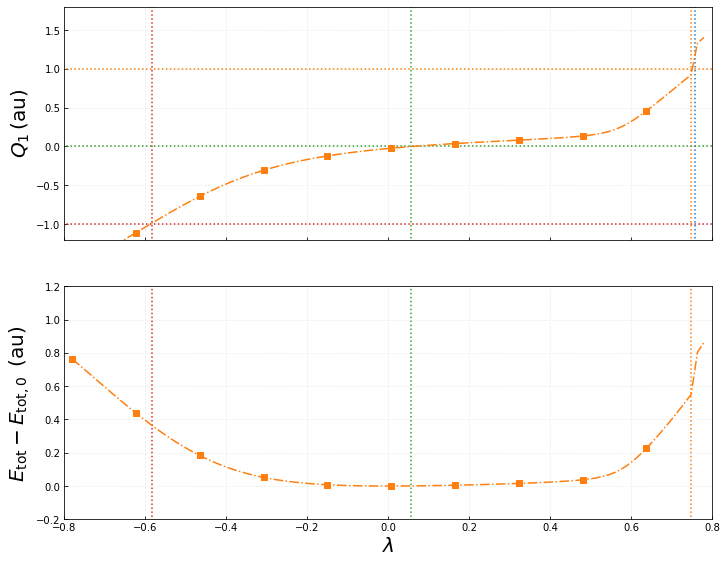

In [3]:
style_dict = {
    '1': dict(linestyle='-.',  marker='s', color='C1',  markersize=6,  markevery=10, label=r"$(\omega, 0.0)$"),
    '2': dict(linestyle='-.',  marker='*', color='C2',  markersize=10, markevery=10, label=r"$(2\omega, 0.0)$"),
    '3': dict(linestyle='-.',  marker='o', color='C3',  markersize=6,  markevery=10, label=r"$(\omega, \omega)$")
}

params = {
        "axes.titlesize":  10, 
        "axes.labelsize":  20, 
        "legend.fontsize": 15,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10, 
        "xtick.direction":'in', 
        "ytick.direction":'in' 
}
mpl.rcParams.update(**params)

k = kk

fig1, ax1 = plt.subplots(2,1,figsize=(10,8),sharex=True)
fig1.subplots_adjust(left=0.09, bottom=0.1, right=0.99, top=0.99, wspace=0.1)

ax1[0].plot(lam_list[:k], pop_1_list[:k],                 **style_dict['1'])
ax1[1].plot(lam_list[:k], etot_1_list[:k],                **style_dict['1'])
tmp_list1 = [ 0.0 for _ in range(kk)]
tmp_list2 = [ 1.0 for _ in range(kk)]
tmp_list3 = [-1.0 for _ in range(kk)]
ax1[0].hlines(1,      -1.0,1.0,colors='C1',linestyle='dotted')
ax1[0].vlines(0.747,  -2.0,2.0,colors='C1',linestyle='dotted')
ax1[0].vlines(0.7572879261889914,  -2.0,2.0,colors='C10',linestyle='dotted')
ax1[1].vlines(0.747,  -2.0,2.0,colors='C1',linestyle='dotted')
ax1[0].hlines(0,      -1.0,1.0,colors='C2',linestyle='dotted')
ax1[0].vlines(0.057,  -2.0,2.0,colors='C2',linestyle='dotted')
ax1[1].vlines(0.057,  -2.0,2.0,colors='C2',linestyle='dotted')
ax1[0].hlines(-1,     -1.0,1.0,colors='C3',linestyle='dotted')
ax1[0].vlines(-0.582, -2.0,2.0,colors='C3',linestyle='dotted')
ax1[1].vlines(-0.582, -2.0,2.0,colors='C3',linestyle='dotted')


props = {'ylim':[-1.2,1.8],'xlim':[-0.8,0.8],'ylabel':r'$Q_1\,$(au)'}
ax1[0].grid(linestyle="--", alpha=0.2)
ax1[0].set(**props)

props = {'ylim':[-0.2,1.2],'ylabel':r'$E_\mathrm{tot}-E_\mathrm{tot,0}\,$ (au)', 'xlabel':r'$\lambda\,$'}
ax1[1].grid(linestyle="--", alpha=0.2)
ax1[1].set(**props);

In [4]:
mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()
dm = mf.make_rdm1()

lam_vals            = [[0.0574943538660819],[0.0]]
frg_list            = [[0,1,2],[3,4,5]]
nelec_required_list = [[10.0], [10.0]]

err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=0, maxiter=500, tol=1e-8,
                                           old_get_fock=old_get_fock)
print("err_vals = \n", err_vals)

err_vals = 
 [[ 0.00101624]
 [-0.00101624]]


In [5]:
mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()
dm = mf.make_rdm1()

lam_vals            = [[-0.5660483342176309],[0.0]]
frg_list            = [[0,1,2],[3,4,5]]
nelec_required_list = [[11.0], [9.0]]

err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=3, maxiter=1000, tol=1e-8,
                                           old_get_fock=old_get_fock)
print("err_vals = \n", err_vals)

mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()
dm = mf.make_rdm1()

lam_vals            = [[-0.561659],[0.0]]
frg_list            = [[0,1,2],[3,4,5]]
nelec_required_list = [[11.0], [9.0]]

err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=3, maxiter=1000, tol=1e-8,
                                           old_get_fock=old_get_fock)
print("err_vals = \n", err_vals)

cycle= 1 E= -151.845599618881  delta_E= 0.182  |g|= 0.244  |ddm|= 2.65
cycle= 2 E= -151.79409574855  delta_E= 0.0515  |g|= 0.106  |ddm|= 0.713
cycle= 3 E= -151.714676325882  delta_E= 0.0794  |g|= 0.109  |ddm|= 0.69
cycle= 4 E= -151.727159481086  delta_E= -0.0125  |g|= 0.0723  |ddm|= 0.133
cycle= 5 E= -151.689372278327  delta_E= 0.0378  |g|= 0.0688  |ddm|= 0.311
cycle= 6 E= -151.708574477921  delta_E= -0.0192  |g|= 0.0541  |ddm|= 0.16
cycle= 7 E= -151.685612561351  delta_E= 0.023  |g|= 0.0483  |ddm|= 0.188
cycle= 8 E= -151.70202116697  delta_E= -0.0164  |g|= 0.0401  |ddm|= 0.134
cycle= 9 E= -151.686383962765  delta_E= 0.0156  |g|= 0.0349  |ddm|= 0.128
cycle= 10 E= -151.693307253824  delta_E= -0.00692  |g|= 0.000901  |ddm|= 0.0549
cycle= 11 E= -151.692815164886  delta_E= 0.000492  |g|= 0.000181  |ddm|= 0.0056
cycle= 12 E= -151.692787741452  delta_E= 2.74e-05  |g|= 9.22e-05  |ddm|= 0.000628
cycle= 13 E= -151.692788026581  delta_E= -2.85e-07  |g|= 2.72e-05  |ddm|= 0.000541
cycle= 14 E= -15

Overwritten attributes  get_fock  of <class 'pyscf.scf.hf.RHF'>


err_vals = 
 [[-0.06512912]
 [ 0.06512912]]
cycle= 1 E= -151.850854906086  delta_E= 0.176  |g|= 0.24  |ddm|=  2.6
cycle= 2 E= -151.799257855911  delta_E= 0.0516  |g|= 0.104  |ddm|= 0.71
cycle= 3 E= -151.722388158817  delta_E= 0.0769  |g|= 0.106  |ddm|= 0.671
cycle= 4 E= -151.733655252522  delta_E= -0.0113  |g|= 0.0697  |ddm|= 0.126
cycle= 5 E= -151.697464426863  delta_E= 0.0362  |g|= 0.0663  |ddm|= 0.299
cycle= 6 E= -151.715497044032  delta_E= -0.018  |g|= 0.0519  |ddm|= 0.151
cycle= 7 E= -151.693687013271  delta_E= 0.0218  |g|= 0.0463  |ddm|= 0.18
cycle= 8 E= -151.7091336434  delta_E= -0.0154  |g|= 0.0384  |ddm|= 0.127
cycle= 9 E= -151.694369569082  delta_E= 0.0148  |g|= 0.0333  |ddm|= 0.122
cycle= 10 E= -151.700873419689  delta_E= -0.0065  |g|= 0.00088  |ddm|= 0.0519
cycle= 11 E= -151.700391253309  delta_E= 0.000482  |g|= 0.000171  |ddm|= 0.00548
cycle= 12 E= -151.700367257058  delta_E= 2.4e-05  |g|= 8.77e-05  |ddm|= 0.000575
cycle= 13 E= -151.700368438488  delta_E= -1.18e-06  |g|= 2

In [6]:
mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()
dm = mf.make_rdm1()


frg_list            = [[0,1,2],[3,4,5]]
nelec_required_list = [[9.0], [11.0]]

lam_vals            = [[0.7572879261889914],[0.0]]
err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=3, maxiter=500, tol=1e-8,
                                           old_get_fock=old_get_fock)

print("Q-Chem CDFT lambda value = {: f}".format(0.7572879261889914))
print("err_vals = \n", err_vals)
pop                 = mf.mulliken_pop(verbose=0)[1]
pop1                = pop[0]+pop[1]+pop[2]
print("pop1 = {: f}".format(pop1))
print()

mf           = scf.RHF(mol)
mf.conv_tol  = 1e-9
mf.verbose   = 0
mf.max_cycle = 100
mf.kernel()
dm = mf.make_rdm1()

lam_vals            = [[0.696164],[0.0]]
err_vals            = cdft_inner_cycle(mf, frg_list, nelec_required_list, lam_vals, dm0=dm, verbose=3, maxiter=500, tol=1e-8,
                                           old_get_fock=old_get_fock)

print("PySCF RDFT lambda value = {: f}".format(0.696164))
print("err_vals = \n", err_vals)
pop                 = mf.mulliken_pop(verbose=0)[1]
pop1                = pop[0]+pop[1]+pop[2]
print("pop1 = {: f}".format(pop1))

cycle= 1 E= -150.118540692737  delta_E= 1.91  |g|=  1.3  |ddm|= 7.83
cycle= 2 E= -151.254965477409  delta_E= -1.14  |g|= 1.94  |ddm|= 7.93
cycle= 3 E= -144.709272887715  delta_E= 6.55  |g|=  2.7  |ddm|= 11.6
cycle= 4 E= -141.135448354324  delta_E= 3.57  |g|= 5.84  |ddm|= 12.3
cycle= 5 E= -117.359270395064  delta_E= 23.8  |g|= 4.78  |ddm|= 10.4
cycle= 6 E= -108.643072223135  delta_E= 8.72  |g|=  6.2  |ddm|= 12.4
cycle= 7 E= -108.401743070523  delta_E= 0.241  |g|=  5.7  |ddm|= 11.3
cycle= 8 E= -108.492249613728  delta_E= -0.0905  |g|= 6.21  |ddm|= 11.2
cycle= 9 E= -108.399199962635  delta_E= 0.093  |g|=  5.7  |ddm|= 11.2
cycle= 10 E= -150.974198346508  delta_E= -42.6  |g|= 2.25  |ddm|= 8.42
cycle= 11 E= -151.790196449422  delta_E= -0.816  |g|= 0.961  |ddm|=    1
cycle= 12 E= -151.90416957262  delta_E= -0.114  |g|= 0.531  |ddm|= 0.569
cycle= 13 E= -150.176141591002  delta_E= 1.73  |g|= 1.18  |ddm|= 7.78
cycle= 14 E= -151.92965062002  delta_E= -1.75  |g|= 0.425  |ddm|=  7.8
cycle= 15 E= -1